# TSCA MaxMin selections

Last modified:06 November 2023<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform
import sys

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [4]:
from model_functions import *

In [5]:
df = pd.read_excel(interim_dir+'final_universe_wMaxMin_061123.xlsx')

In [6]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,lvl_cluster_d,lvl3_centroid,lvl3_centroid2,lvl3_analogues,lvl3_Dist,final_centroid,final_dist,group,group_str,MaxMin_picks
0,DTXSID6071908,DSSTox_High,N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...,68957-63-1,Single Compound,CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...,"InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...",IOQHTIQMCISFKB-UHFFFAOYSA-N,C11H8F15NO4S,535.22,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.000000,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",1
1,DTXSID8071358,DSSTox_High,N-Methyl-perfluoro-1-heptanesulfonamide,68259-14-3,Single Compound,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,"InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...",KDHCALLFPWZTPN-UHFFFAOYSA-N,C8H4F15NO2S,463.16,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.640000,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0
2,DTXSID1071907,DSSTox_High,N-Ethylpentadecafluoro-1-heptanesulfonamide,68957-62-0,Single Compound,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...",WMOMXEHEPXLIAV-UHFFFAOYSA-N,C9H6F15NO2S,477.19,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.615385,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0
3,DTXSID001026645,DSSTox_Low,"1,1,2,2,3,3,4,4,5,5,6,6,7,7,7-Pentadecafluoro-...",167398-54-1,Single Compound,OCCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,"InChI=1S/C9H6F15NO3S/c10-3(11,4(12,13)6(16,17)...",LJJUSVBJKZXMCP-UHFFFAOYSA-N,C9H6F15NO3S,493.19,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.660714,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0
4,DTXSID301026644,DSSTox_Low,(Perfluoroheptyl)(sulfonylamino)acetic acid,1003194-00-0,Single Compound,OC(=O)CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,"InChI=1S/C9H4F15NO4S/c10-3(11,4(12,13)6(16,17)...",LAAXCIZXZCKWFF-UHFFFAOYSA-N,C9H4F15NO4S,507.17,...,NaN,NaN,NaN,NaN,NaN,DTXSID6071908,0.592593,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0


#### Constraining the universe to TSCA and computing centroids and MaxMin from the contrained inventory

Calculate centroids for terminal categories but constraining the substances to those with substances on the TSCA inventory

In [7]:
pfas_tsca = df[df['TSCA_STATUS']!= 'unclassified']

In [8]:
pfas_tsca.shape

(658, 75)

In [14]:
pfas_tsca[pfas_tsca['ID'].isnull()]['TSCA_STATUS'].value_counts()

inactive    324
active      293
Name: TSCA_STATUS, dtype: int64

In [15]:
results_subcats = {}
for i, group in pfas_tsca.groupby('group_str'):
    try:
        a = mk_fp(group)
    except Exception as error:
        print(error)
    else:
        results_subcats[i] = a


In [16]:
distances_subcats = {}
for k,v in results_subcats.items():
    a = distance_matrix(results_subcats[k])
    distances_subcats[k] = a

In [17]:
len(results_subcats)


71

In [18]:
len({k:v.shape[0] for k,v in results_subcats.items() if v.shape[0] >5})

27

In [19]:
len(distances_subcats)

71

In [20]:
centres = []
for i,group in pfas_tsca.groupby('group_str'):
    try:
        m = medoid_calc(distances_subcats[i])
        centres.append(m)
    except Exception as error:
        print(error)


In [21]:
pfas_tsca['tsca_centroid'] = pfas_tsca['dtxsid'].apply(lambda x: 'centroid' if x in centres else np.nan)

/tmp/ipykernel_1996059/1021335603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfas_tsca['tsca_centroid'] = pfas_tsca['dtxsid'].apply(lambda x: 'centroid' if x in centres else np.nan)


In [22]:
pfas_tsca.tsca_centroid.value_counts()

centroid    71
Name: tsca_centroid, dtype: int64

In [23]:
df3 = pfas_tsca.copy()

In [24]:
df_3 = df3.set_index('dtxsid')

In [25]:
members = {}

for i, group in df_3.groupby('group_str'):
    subset = group[['group_str', 'tsca_centroid']]
    try: 
        for x, y in subset.iterrows():
            a, b = y
            if b == 'centroid':
                #print(x)
                c = [distances_subcats[i][x].index, distances_subcats[i][x].values]
                members[x] = c
    except Exception as error:
            print(error)

In [26]:
cluster_members = pd.DataFrame(list(members.items()))
cluster_members.columns = ['tsca_centroid', 1]
cluster_members[['lvl2_analogues','lvl2_Dist']] = pd.DataFrame(cluster_members[1].tolist(), index= cluster_members.index)
cluster_members.drop([1], axis = 1, inplace = True)
cluster_members_1 = cluster_members.apply(pd.Series.explode)
cluster_members_1.head()


,tsca_centroid,lvl2_analogues,lvl2_Dist
0,DTXSID1071662,DTXSID6071908,0.375
0,DTXSID1071662,DTXSID8071358,0.625
0,DTXSID1071662,DTXSID1071907,0.6
0,DTXSID1071662,DTXSID6071665,0.391304
0,DTXSID1071662,DTXSID1067629,0.625


In [27]:
df3['tsca_centroid_id'] = df3.apply(lambda x: x['dtxsid'] if x['tsca_centroid'] == 'centroid' else np.nan, axis = 1)


In [28]:
df3 = df3.sort_values(by = ['group_str', 'tsca_centroid_id'], ascending = [True, False])

In [29]:
df3['tsca_centroid_id2'] = df3['tsca_centroid_id'].fillna(method = 'ffill')


In [30]:
mydict_ = {}
for i, group in df3.groupby('tsca_centroid_id2'):
    k = [n for n in group['tsca_centroid_id2'] if n != ' '][0]
    v = list(group['dtxsid'])
    mydict_[k] = v


In [31]:
len(list(mydict_.values()))

71

In [32]:
dist_ = []
for i, group in cluster_members_1.groupby('tsca_centroid'):
    a = cluster_members_1[(cluster_members_1['tsca_centroid'] == i) & (cluster_members_1['lvl2_analogues'].isin(mydict_[i]))]
    dist_.append(a)

In [33]:
dist_df = pd.concat([e for e in dist_])

In [34]:
df3_w = pd.merge(df3, dist_df[['lvl2_analogues', 'lvl2_Dist']], left_on = 'dtxsid', right_on = 'lvl2_analogues', how = 'left')


In [35]:
df3_w.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'smiles', 'Structure_InChI', 'Structure_InChIKey',
       'Structure_Formula', 'Structure_MolWt', 'Structure_SMILES_2D-QSAR',
       'Canonical_QSARr', 'TSCA_STATUS', 'chain_length', 'category',
       'MolWeight', 'LogP_pred', 'LogP_predRange', 'AD_LogP', 'AD_index_LogP',
       'Conf_index_LogP', 'MP_pred', 'MP_predRange', 'AD_MP', 'AD_index_MP',
       'Conf_index_MP', 'BP_pred', 'BP_predRange', 'AD_BP', 'AD_index_BP',
       'Conf_index_BP', 'LogVP_pred', 'VP_predRange', 'AD_VP', 'AD_index_VP',
       'Conf_index_VP', 'LogWS_pred', 'WS_predRange', 'AD_WS', 'AD_index_WS',
       'Conf_index_WS', 'LogHL_pred', 'HL_predRange', 'AD_HL', 'AD_index_HL',
       'Conf_index_HL', 'ID', 'tsca_match', 'subcategory', 'cluster',
       'cluster_centroid', 'centroid_x', 'centroid2', 'centroid_y',
       'analogues', 'Dist', 'level2_cluster_centroid', 'cluster_d',
       'lvl2_centroid', 'lvl2_centro

In [36]:
df3_w.rename(columns = {'lvl2_analogues_x' : 'lvl2_analogues', 'lvl2_Dist_x' : 'lvl2_Dist', 'lvl2_analogues_y' : 'tsca_analogues' ,'lvl2_Dist_y' : 'tsca_dist'},  inplace = True)

In [37]:
df3_w.head()

,dtxsid,DSSTox_QC-Level,Substance_Name,Substance_CASRN,Substance_Type,smiles,Structure_InChI,Structure_InChIKey,Structure_Formula,Structure_MolWt,...,final_centroid,final_dist,group,group_str,MaxMin_picks,tsca_centroid,tsca_centroid_id,tsca_centroid_id2,tsca_analogues,tsca_dist
0,DTXSID1071662,DSSTox_High,N-Ethyl-pentadecafluoro-N-(2-hydroxyethyl)-1-h...,68555-73-7,Single Compound,CCN(CCO)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C...,"InChI=1S/C11H10F15NO3S/c1-2-27(3-4-28)31(29,30...",HINASMOVWHGCAK-UHFFFAOYSA-N,C11H10F15NO3S,521.24,...,DTXSID6071908,0.375000,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0,centroid,DTXSID1071662,DTXSID1071662,DTXSID1071662,0.0
1,DTXSID6071908,DSSTox_High,N-Ethyl-N-((pentadecafluoroheptyl)sulphonyl)gl...,68957-63-1,Single Compound,CCN(CC(O)=O)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)...,"InChI=1S/C11H8F15NO4S/c1-2-27(3-4(28)29)32(30,...",IOQHTIQMCISFKB-UHFFFAOYSA-N,C11H8F15NO4S,535.22,...,DTXSID6071908,0.000000,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",1,NaN,NaN,DTXSID1071662,DTXSID6071908,0.375
2,DTXSID8071358,DSSTox_High,N-Methyl-perfluoro-1-heptanesulfonamide,68259-14-3,Single Compound,CNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,"InChI=1S/C8H4F15NO2S/c1-24-27(25,26)8(22,23)6(...",KDHCALLFPWZTPN-UHFFFAOYSA-N,C8H4F15NO2S,463.16,...,DTXSID6071908,0.640000,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0,NaN,NaN,DTXSID1071662,DTXSID8071358,0.625
3,DTXSID1071907,DSSTox_High,N-Ethylpentadecafluoro-1-heptanesulfonamide,68957-62-0,Single Compound,CCNS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,"InChI=1S/C9H6F15NO2S/c1-2-25-28(26,27)9(23,24)...",WMOMXEHEPXLIAV-UHFFFAOYSA-N,C9H6F15NO2S,477.19,...,DTXSID6071908,0.615385,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0,NaN,NaN,DTXSID1071662,DTXSID1071907,0.6
4,DTXSID6071665,DSSTox_High,Pentadecafluoro-N-(2-hydroxyethyl)-N-methyl-1-...,68555-76-0,Single Compound,CN(CCO)S(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,"InChI=1S/C10H8F15NO3S/c1-26(2-3-27)30(28,29)10...",UIZUTEDYGNRNSW-UHFFFAOYSA-N,C10H8F15NO3S,507.21,...,DTXSID6071908,0.509804,"('FASA based PFAA precursors', 'gte7', nan, nan)","('FASA based PFAA precursors', 'gte7', nan, nan)",0,NaN,NaN,DTXSID1071662,DTXSID6071665,0.391304


Now have our centroids and pairwise distances for the tsca_pfas set

In [38]:
cats = df3_w['group_str'].unique().tolist()


In [39]:
def content_max(df,  k = None):
    content = {}
    tdf = df[df['group_str'] == k]
    content['t_dict'] = {k:Chem.MolFromSmiles(v) for k,v in zip(tdf['dtxsid'], tdf['smiles'])}
    content['fp_dict'] = [AllChem.GetMorganFingerprintAsBitVect(i, 3, 1024) for i in content['t_dict'].values()]
    content['nfp_dict'] = len(content['fp_dict'])
    content['t_index'] = {k:v for k,v in enumerate(content['t_dict'].keys())} 
    content['k'] = k
    
    return content

In [40]:
lte_summaries = []
for k in cats:
    try:
        lte_summaries.append(content_max(df3_w, k))
    except Exception as error:
        print(k)


In [41]:
from rdkit.SimDivFilters import MaxMinPicker

In [42]:
def picker_func(fps, n1, start_with  = 1, n2 = 3, label = None, fps_index = None):
    picker_dict = {}
    mmp = MaxMinPicker()
    picker_dict['label'] = label
    picker_dict['indices'] = mmp.LazyBitVectorPick(fps,n1, start_with+n2, [0])
    picker_dict['diverse_chems'] = [fps_index[x] for x in picker_dict['indices']]
    return picker_dict


In [43]:
picker_lst = []
for i in range(len(lte_summaries)):
    if lte_summaries[i]['nfp_dict'] > 5:
        picker_lst.append(picker_func(lte_summaries[i]['fp_dict'], n1 =lte_summaries[i]['nfp_dict'], n2 = 3, label = lte_summaries[i]['k'], fps_index = lte_summaries[i]['t_index'] ))



In [44]:
mylst2 = []
for i in range(len(picker_lst)):
    mylst2.append(picker_lst[i]['diverse_chems'])


In [45]:
mylst2 = [e for a in mylst2 for e in a]

In [46]:
len(mylst2)

108

In [47]:
df3_w['MaxMin_tsca_picks'] = df3_w['dtxsid'].apply(lambda x: 1 if x in mylst2 else 0)


In [48]:
df3_w.MaxMin_tsca_picks.value_counts()

0    550
1    108
Name: MaxMin_tsca_picks, dtype: int64

In [49]:
groups_ =df3_w.groupby('group_str').agg({'MaxMin_tsca_picks' : 'sum'})

In [50]:
groups_[groups_.MaxMin_tsca_picks >0].shape

(27, 1)

In [51]:
groups_[groups_.MaxMin_tsca_picks < 4].shape

#groups.apply(lambda g: g[g['B'] == g['B'].max()]))

(44, 1)

In [52]:
final_df = pd.merge(df, df3_w[['dtxsid', 
       'tsca_centroid', 'tsca_centroid_id', 'tsca_centroid_id2',
       'tsca_analogues', 'tsca_dist', 'MaxMin_tsca_picks']], on = 'dtxsid', how = 'left')


In [53]:
final_df.columns

Index(['dtxsid', 'DSSTox_QC-Level', 'Substance_Name', 'Substance_CASRN',
       'Substance_Type', 'smiles', 'Structure_InChI', 'Structure_InChIKey',
       'Structure_Formula', 'Structure_MolWt', 'Structure_SMILES_2D-QSAR',
       'Canonical_QSARr', 'TSCA_STATUS', 'chain_length', 'category',
       'MolWeight', 'LogP_pred', 'LogP_predRange', 'AD_LogP', 'AD_index_LogP',
       'Conf_index_LogP', 'MP_pred', 'MP_predRange', 'AD_MP', 'AD_index_MP',
       'Conf_index_MP', 'BP_pred', 'BP_predRange', 'AD_BP', 'AD_index_BP',
       'Conf_index_BP', 'LogVP_pred', 'VP_predRange', 'AD_VP', 'AD_index_VP',
       'Conf_index_VP', 'LogWS_pred', 'WS_predRange', 'AD_WS', 'AD_index_WS',
       'Conf_index_WS', 'LogHL_pred', 'HL_predRange', 'AD_HL', 'AD_index_HL',
       'Conf_index_HL', 'ID', 'tsca_match', 'subcategory', 'cluster',
       'cluster_centroid', 'centroid_x', 'centroid2', 'centroid_y',
       'analogues', 'Dist', 'level2_cluster_centroid', 'cluster_d',
       'lvl2_centroid', 'lvl2_centro

In [54]:
writer = pd.ExcelWriter(interim_dir+'final_universe_categorisatons_wtsca_constraints_110623.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

final_df.to_excel(writer)


writer.close()


In [55]:
from venn import venn

In [56]:
#final_df.tsca_centroid_id2

In [57]:
mydict3 = {
           'Unconstrained centroid' : set(final_df['final_centroid'].unique().tolist()),
           
           'Unconstrained MaxMin selections' : set(final_df[final_df['MaxMin_picks'] ==1]['dtxsid'].tolist()),
           'TSCA inventory MaxMin selections' : set(final_df[final_df['MaxMin_tsca_picks']==1]['dtxsid'].tolist()),
           'TSCA inventory centroid' : set(final_df['tsca_centroid_id2'].unique().tolist()),
           }

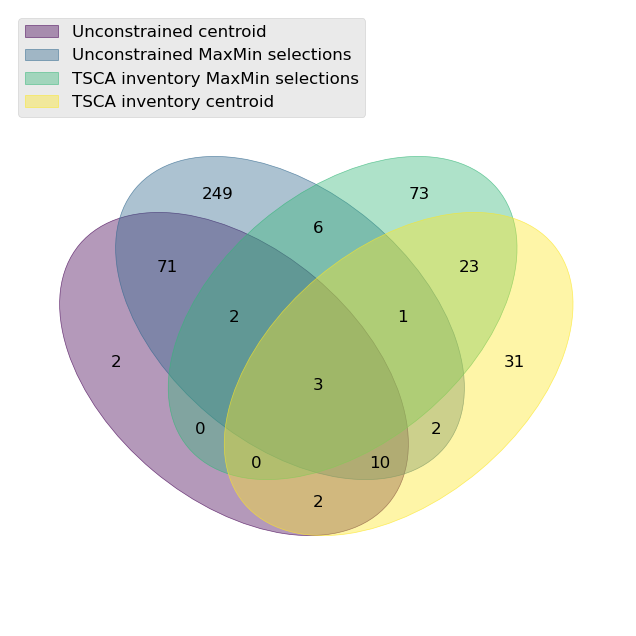

In [58]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(10, 8))
#plt.figure(figsize=(18, 8))
venn(mydict3, cmap="viridis", fontsize=12, legend_loc="upper left",ax = ax )
f.savefig(figures_dir+'Figure7_061123.png', dpi = 300)

In [59]:
71/90

0.7888888888888889